# ドル円為替レート 週足, Parabolic SAR

In [4]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = 'USDJPY=X'
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='2y', interval='1wk')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-12-12 00:00:00+00:00,137.503998,137.942001,134.681000,136.699997,0,0.0,0.0
2022-12-19 00:00:00+00:00,136.029999,137.451996,131.016998,132.759995,0,0.0,0.0
2022-12-26 00:00:00+00:00,132.770004,134.395004,131.110001,131.110001,0,0.0,0.0
2023-01-02 00:00:00+00:00,130.845001,134.740997,129.533997,132.080002,0,0.0,0.0
2023-01-09 00:00:00+00:00,131.862000,132.854004,127.468002,127.870003,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-11 00:00:00+00:00,152.904007,156.746002,152.869995,154.320007,0,0.0,0.0
2024-11-18 00:00:00+00:00,154.664001,155.871994,153.397003,154.770004,0,0.0,0.0
2024-11-25 00:00:00+00:00,154.145996,154.695999,149.589996,149.750000,0,0.0,0.0


## パラボリック SAR

In [5]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 週足チャートとパラボリック SAR

401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/USDJPY=X?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=USDJPY%3DX&crumb=%7B%22finance%22%3A%7B%22result%22%3Anull%2C%22error%22%3A%7B%22code%22%3A%22Unauthorized%22%2C%22description%22%3A%22Invalid+Cookie%22%7D%7D%7D


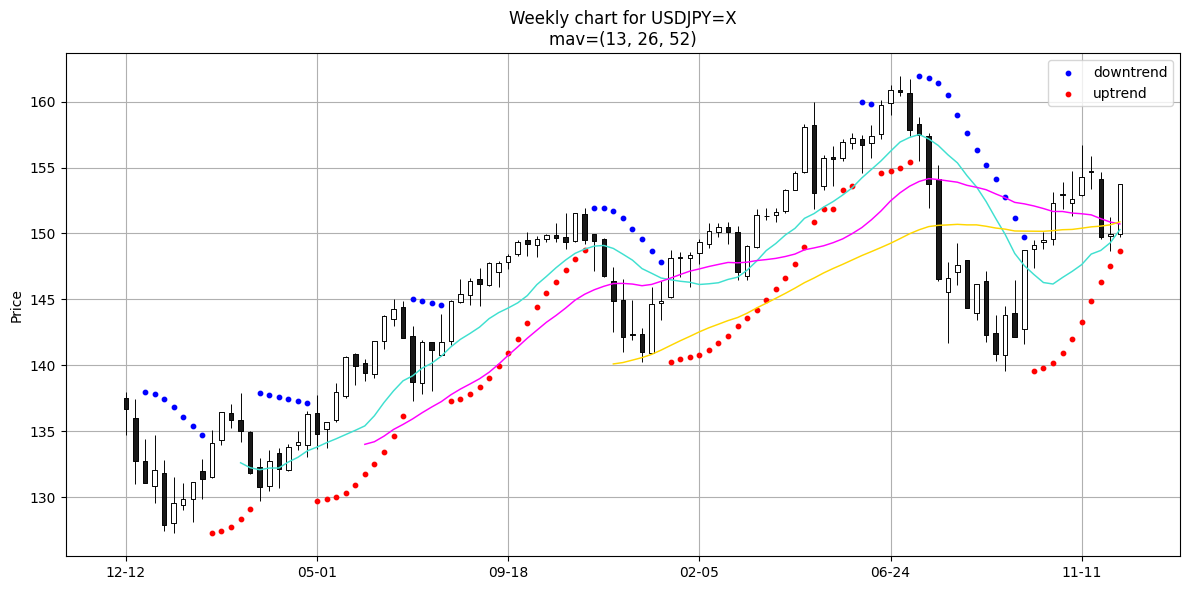

In [6]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=10,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=10,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(13, 26, 52),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Weekly chart for %s (%s)\nmav=(13, 26, 52)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Weekly chart for %s\nmav=(13, 26, 52)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('weekly_chart_exchange_psar.png')
plt.show()

In [7]:
df.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-12-09 00:00:00+00:00,149.931,153.770996,149.697006,153.744995,0,0.0,0.0


In [8]:
df.tail(2)['Close']

Date
2024-12-02 00:00:00+00:00    149.979996
2024-12-09 00:00:00+00:00    153.744995
Name: Close, dtype: float64

In [9]:
df.tail(2)['Close'].diff()

Date
2024-12-02 00:00:00+00:00         NaN
2024-12-09 00:00:00+00:00    3.764999
Name: Close, dtype: float64

In [10]:
df['Close'].rolling(26).mean().tail(5)

Date
2024-11-11 00:00:00+00:00    151.495770
2024-11-18 00:00:00+00:00    151.411924
2024-11-25 00:00:00+00:00    151.123078
2024-12-02 00:00:00+00:00    150.864231
2024-12-09 00:00:00+00:00    150.723270
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(52).mean().tail(5)

Date
2024-11-11 00:00:00+00:00    150.399192
2024-11-18 00:00:00+00:00    150.501307
2024-11-25 00:00:00+00:00    150.557846
2024-12-02 00:00:00+00:00    150.656327
2024-12-09 00:00:00+00:00    150.879884
Name: Close, dtype: float64